In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
import tensorflow as tf 
from tensorflow import keras
import csv
import os
from keras import backend as K
import math
from scipy.stats import norm
import os
import re
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [12]:
num_epochs = 40 
num_conv = 3 
train_per = .75 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#python -m tensorboard.main --logdir=<path to log file> --port=6006
#in directory of logs in anaconda prompt
#had to install cuda 

In [13]:
cutoff = 16000
#this is the length I'm cutting off the data just arbitrarily when I'm using multiple catalogs
#but here since i'm only using one it doesn't matter 

master_rshift = []
master_dist_mod = [] #errors added on 
master_glat = [] 
master_glon = [] 
bulkflows = [] 
#I use this to determine the shortest length of data when using varied catalogs 

for x in os.listdir("C:/Users/19133/Documents/Research/Feldman/Catalogs/1500_cats_5_rots"):
    data = np.load("C:/Users/19133/Documents/Research/Feldman/Catalogs/1500_cats_5_rots/"+x)
    master_rshift.append(data['redshift'][:cutoff])
    master_dist_mod.append(data['distm'][:cutoff] + data['distmerr'][:cutoff])
    master_glat.append(data['glat'][:cutoff])
    master_glon.append(data['glon'][:cutoff])
    bulkflows.append(data['bulkflow'])
    
master_bulkflows = np.array(bulkflows) #cutoff is number of files 

#I scale the data to be between 0 and 1 here, where I am scaling it by the 
#largest value of all the data, as opposed to scaling each by 
#the maximum of that array respectively 
#not sure if this is the best approach? 

redshift = np.array(master_rshift)/np.max(np.concatenate(np.array(master_rshift))) 
distm = np.array(master_dist_mod)/np.max(np.concatenate(np.array(master_dist_mod)))
glat = np.array(master_glat)/np.max(np.concatenate(np.array(master_glat)))
glon = np.array(master_glon)/np.max(np.concatenate(np.array(master_glon)))

x_max = max(master_bulkflows[:,0])
y_max = max(master_bulkflows[:,1])
z_max = max(master_bulkflows[:,2])
bf_max = max(x_max, y_max, z_max)
#that is different! 

master_bulkflows_scaled = [] 
for x in master_bulkflows: 
    master_bulkflows_scaled.append(x/np.array([bf_max,bf_max,bf_max]))

In [14]:
X = np.stack([redshift,distm,glat,glon],axis=-1) 
y = np.array(master_bulkflows_scaled)

In [15]:
#random selection, mixing it up 
test_percent = 0.3

indx1 = np.arange(0,len(X))
indx2 = np.random.choice(indx1, size=int(len(X)*test_percent), replace=False)
for x in indx1:
    if x in indx2:
        indx1 = np.delete(indx1,np.where(indx1 == x))
    else:
        True

X_train,X_test = (X[indx1], X[indx2])
y_train,y_test = (y[indx1], y[indx2])

In [16]:
#not random selection 
train_percent = 0.75
X_train,X_test = (X[:int(len(X)*train_percent)], X[int(len(X)*train_percent)::])
y_train,y_test = (y[:int(len(y)*train_percent)], y[int(len(y)*train_percent)::])

In [17]:
#Feldmans 
tf.random.set_seed(982369253487)

num_conv = 7 

inputs = tf.keras.Input(shape=X_train.shape[1:])
#print(inputs)

#here, it's like adding a first layer, where the (inputs) means you're putting the last thru this one 
x = tf.keras.layers.Conv1D(64, 16, activation='relu')(inputs)
#print(x.shape)
#here you're doing the same thing, putting the last (x) in this new layer (x2) 
#the input shape is from the shape that the previous (x) CONV layer outputs 
#I don't know quite what the shape *means*, but you have to basically have the 
#input shape of a layer be whatever shape the last one output 
x2 = tf.keras.layers.Conv1D(32, 8, input_shape=x.shape[1:], activation='tanh')(x) # tanh
#print(x2.shape[1:])
x3 = tf.keras.layers.Conv1D(32, 6, input_shape=x2.shape[1:], activation='relu')(x2)

if num_conv > 3:
    x4 = tf.keras.layers.Conv1D(32, 6, input_shape=x3.shape[1:], activation='tanh')(x3)
    x5 = tf.keras.layers.Conv1D(32, 6, input_shape=x4.shape[1:], activation='relu')(x4)

if num_conv > 5:
    x6 = tf.keras.layers.Conv1D(32, 6, input_shape=x5.shape[1:], activation='tanh')(x5)
    x7 = tf.keras.layers.Conv1D(32, 4, input_shape=x6.shape[1:], activation='relu')(x6)

if num_conv > 7:
    x8 = tf.keras.layers.Conv1D(32, 4, input_shape=x5.shape[1:], activation='tanh')(x7)
    x9 = tf.keras.layers.Conv1D(32, 4, input_shape=x6.shape[1:], activation='relu')(x8)

#now to put in our last layer, the dense layer, we have to flatten it to get our 3D single arrays 
#Flatten is itself a type of layer 
if num_conv == 3:
    xf = tf.keras.layers.Flatten()(x3)
if num_conv == 5:
    xf = tf.keras.layers.Flatten()(x5)
if num_conv == 7:
    xf = tf.keras.layers.Flatten()(x7)
if num_conv == 9:
    xf = tf.keras.layers.Flatten()(x9)


outputs = tf.keras.layers.Dense(3,activation='linear')(xf)

model1 = tf.keras.Model(inputs=inputs,outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model1.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model1.fit(X_train,y_train,epochs=40,validation_split = 0.3,
           callbacks = [tensorboard_callback])

Epoch 1/40
124/124 [==============================] - 208s 2s/step - loss: 0.0805 - accuracy: 0.3636 - val_loss: 0.0666 - val_accuracy: 0.3300
Epoch 2/40
124/124 [==============================] - 201s 2s/step - loss: 0.0720 - accuracy: 0.4650 - val_loss: 0.0631 - val_accuracy: 0.3928
Epoch 3/40
124/124 [==============================] - 202s 2s/step - loss: 0.0639 - accuracy: 0.5438 - val_loss: 0.0635 - val_accuracy: 0.4070
Epoch 4/40
124/124 [==============================] - 202s 2s/step - loss: 0.0574 - accuracy: 0.5555 - val_loss: 0.0623 - val_accuracy: 0.4354
Epoch 5/40
124/124 [==============================] - 201s 2s/step - loss: 0.0511 - accuracy: 0.6098 - val_loss: 0.0629 - val_accuracy: 0.4301
Epoch 6/40
124/124 [==============================] - 201s 2s/step - loss: 0.0429 - accuracy: 0.6527 - val_loss: 0.0638 - val_accuracy: 0.4295
Epoch 7/40
124/124 [==============================] - 202s 2s/step - loss: 0.0356 - accuracy: 0.6513 - val_loss: 0.0625 - val_accuracy: 0.4366

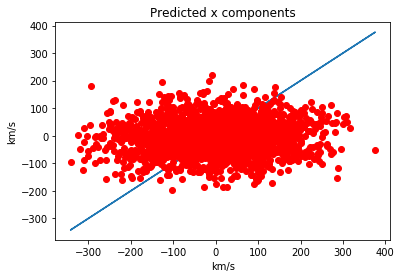

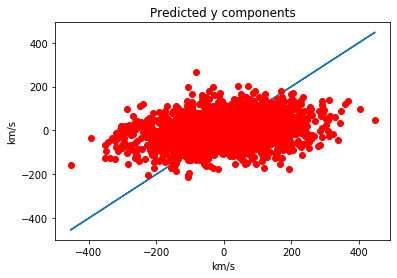

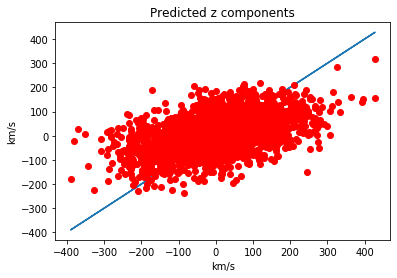

In [19]:
#this is with random selection 
#do tensorboard!
y_pred = model1.predict(X_test)
plt.plot(y_test[:,0]*x_max,y_test[:,0]*x_max)
plt.plot(y_test[:,0]*x_max,y_pred[:,0]*x_max,'ro')
#plt.ylim(-15,0)
plt.title('Predicted x components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.savefig('x')
plt.show()

plt.plot(y_test[:,1]*y_max,y_test[:,1]*y_max)
plt.plot(y_test[:,1]*y_max,y_pred[:,1]*y_max,'ro')
#plt.ylim(-5,10)
plt.title('Predicted y components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.savefig('y')
plt.show()

plt.plot(y_test[:,2]*z_max,y_test[:,2]*z_max)
plt.plot(y_test[:,2]*z_max,y_pred[:,2]*z_max,'ro')
#plt.ylim(-10,2)
plt.title('Predicted z components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.savefig('z')
plt.show()

In [ ]:
#this is with random selection 

y_pred = model1.predict(X_test)
plt.plot(y_test[:,0]*x_max,y_test[:,0]*x_max)
plt.plot(y_test[:,0]*x_max,y_pred[:,0]*x_max,'ro')
#plt.ylim(-15,0)
plt.title('Predicted x components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

plt.plot(y_test[:,1]*y_max,y_test[:,1]*y_max)
plt.plot(y_test[:,1]*y_max,y_pred[:,1]*y_max,'ro')
#plt.ylim(-5,10)
plt.title('Predicted y components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

plt.plot(y_test[:,2]*z_max,y_test[:,2]*z_max)
plt.plot(y_test[:,2]*z_max,y_pred[:,2]*z_max,'ro')
#plt.ylim(-10,2)
plt.title('Predicted z components')
plt.xlabel('km/s')
plt.ylabel('km/s')
plt.show()

#300 catalogs, rotated 20 times each
#see difference between this and random selection 
#then make sure rotation codes are same? - did that 

In [ ]:
len(master_rshift)

In [ ]:
x_preds = y_pred[:,0]*x_max
y_preds = y_pred[:,1]*y_max
z_preds = y_pred[:,2]*z_max

bulkflows_pred = np.sqrt(x_preds**2 + y_preds**2 + z_preds**2)
bulkflows_pred_yz = np.sqrt(y_preds**2 + z_preds**2)

x_true = y_test[:,0]*x_max
y_true = y_test[:,1]*y_max
z_true = y_test[:,2]*z_max

bulkflows_true = np.sqrt(x_true**2 + y_true**2 + z_true**2)
bulkflows_true_yz = np.sqrt(y_true**2 + z_true**2)

In [ ]:
plt.plot(bulkflows_true,bulkflows_pred,'ro')
plt.plot(bulkflows_true,bulkflows_true,'bo')

In [ ]:
plt.plot(bulkflows_true_yz,bulkflows_pred_yz,'ro')
plt.plot(bulkflows_true_yz,bulkflows_true_yz,'bo')